In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset


import zipfile
with zipfile.ZipFile('/content/pascal-voc-2012-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset
License(s): unknown
100% 3.52G/3.52G [00:51<00:00, 57.8MB/s]
100% 3.52G/3.52G [00:51<00:00, 73.3MB/s]


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import xml.etree.ElementTree as ET
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Adjust this if you want to handle multiple classes

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        return boxes_tensor, labels_tensor

# Data Transformation
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

In [ ]:
dataset = PascalVOCDataset(root_dir='/content/VOC2012_train_val/VOC2012_train_val', transform=transform)
subset_size = int(0.2 * len(dataset))
dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Initialize Faster R-CNN
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 134MB/s]


In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        running_loss += losses.item()

    return running_loss / len(dataloader)


In [ ]:
def evaluate_with_accuracy(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                target_boxes = target['boxes'].cpu().numpy()

                matched = 0
                for gt_box in target_boxes:
                    for pred_box in pred_boxes:
                        iou = compute_iou(gt_box, pred_box)
                        if iou > iou_threshold:
                            matched += 1
                            break

                correct += matched
                total += len(target_boxes)

    accuracy = correct / total if total > 0 else 0
    return accuracy


In [ ]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

In [ ]:
print(f"Using device: {device}")


Using device: cuda


In [ ]:
save_dir = '/content/drive/MyDrive/models'

train_losses = []
accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    try:
        # Start of the epoch
        print(f"Starting Epoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        train_loss = train_one_epoch(model, dataloader, optimizer, device)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1} Loss: {train_loss:.4f}")

        # Evaluate accuracy
        accuracy = evaluate_with_accuracy(model, dataloader, device)
        accuracies.append(accuracy)
        print(f"Epoch {epoch+1} Accuracy: {accuracy:.2f}")

        # Save the model after each epoch
        model_path = f"{save_dir}/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

    except Exception as e:
        # Handle errors during training or evaluation
        print(f"Error during epoch {epoch+1}: {e}")


mkdir: missing operand
Try 'mkdir --help' for more information.
Starting Epoch 1/10
Epoch 1 Loss: 0.9426
Epoch 1 Accuracy: 0.29
Model saved at /content/drive/MyDrive/models/model_epoch_1.pth
Starting Epoch 2/10
Epoch 2 Loss: 0.9228
Epoch 2 Accuracy: 0.30
Model saved at /content/drive/MyDrive/models/model_epoch_2.pth
Starting Epoch 3/10
Epoch 3 Loss: 0.8990
Epoch 3 Accuracy: 0.28
Model saved at /content/drive/MyDrive/models/model_epoch_3.pth
Starting Epoch 4/10
Epoch 4 Loss: 0.8990
Epoch 4 Accuracy: 0.30
Model saved at /content/drive/MyDrive/models/model_epoch_4.pth
Starting Epoch 5/10
Epoch 5 Loss: 0.8734
Epoch 5 Accuracy: 0.32
Model saved at /content/drive/MyDrive/models/model_epoch_5.pth
Starting Epoch 6/10
Epoch 6 Loss: 0.8565
Epoch 6 Accuracy: 0.32
Model saved at /content/drive/MyDrive/models/model_epoch_6.pth
Starting Epoch 7/10
Epoch 7 Loss: 0.8430
Epoch 7 Accuracy: 0.32
Model saved at /content/drive/MyDrive/models/model_epoch_7.pth
Starting Epoch 8/10
Epoch 8 Loss: 0.8282
Epoch 

In [ ]:
model_save_path = "rcnn_model_final.pth"
torch.save(model.state_dict(), model_save_path)

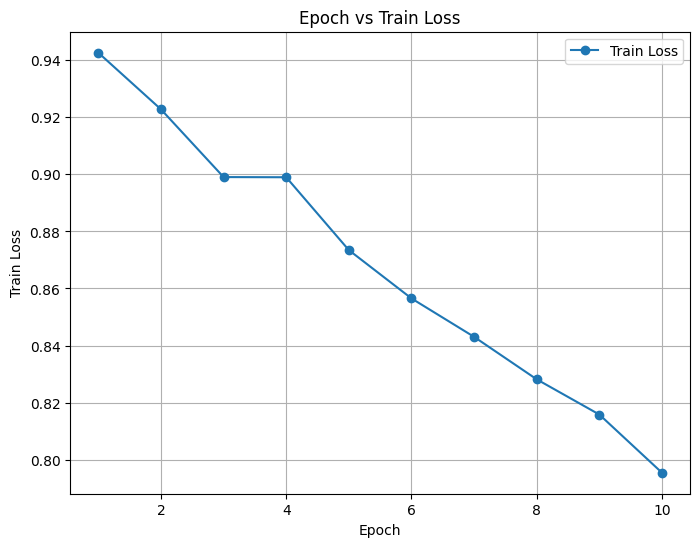

In [ ]:
import matplotlib.pyplot as plt

# Plot Epoch vs Train Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Epoch vs Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)
plt.legend()
plt.show()

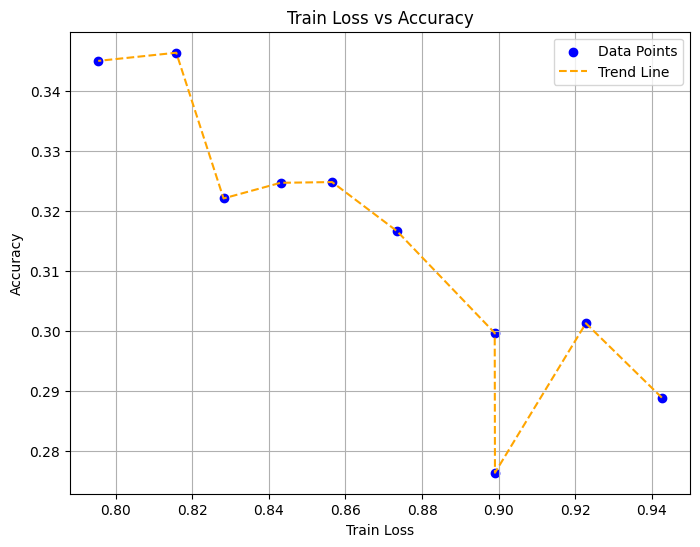

In [ ]:
# Plot Train Loss vs Accuracy
plt.figure(figsize=(8, 6))
plt.scatter(train_losses, accuracies, color='blue', label='Data Points')
plt.plot(train_losses, accuracies, linestyle='--', color='orange', label='Trend Line')
plt.title('Train Loss vs Accuracy')
plt.xlabel('Train Loss')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


Training complete. Plotting results...


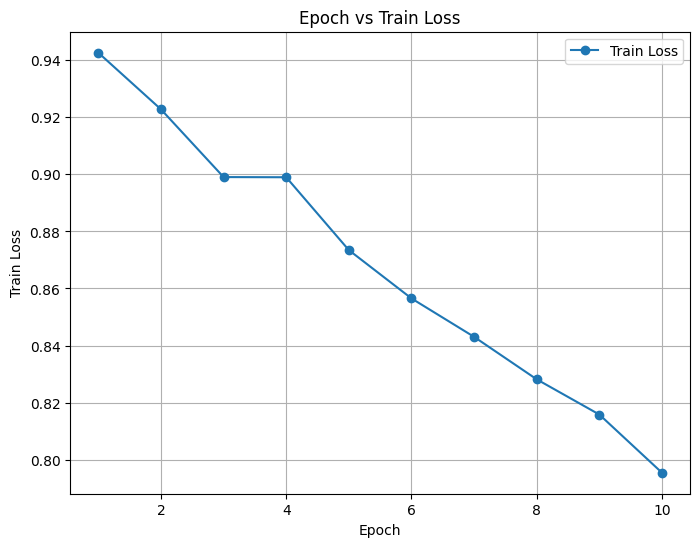

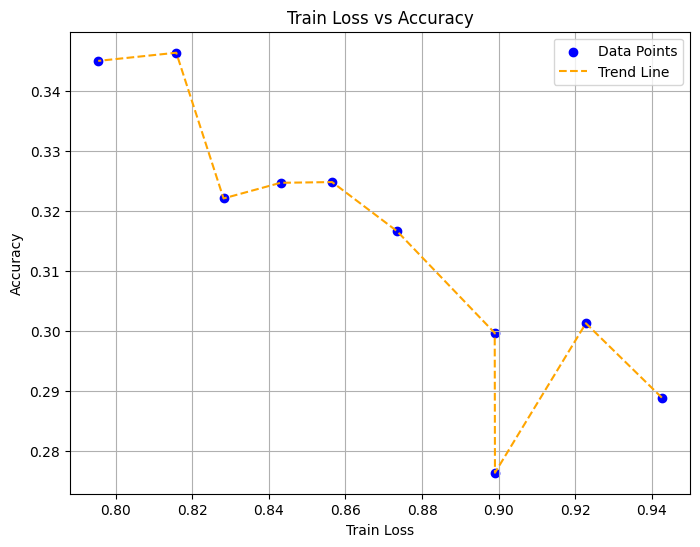

In [ ]:
# After training is complete
print("Training complete. Plotting results...")

# Epoch vs Train Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Epoch vs Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)
plt.legend()
plt.show()

# Train Loss vs Accuracy
plt.figure(figsize=(8, 6))
plt.scatter(train_losses, accuracies, color='blue', label='Data Points')
plt.plot(train_losses, accuracies, linestyle='--', color='orange', label='Trend Line')
plt.title('Train Loss vs Accuracy')
plt.xlabel('Train Loss')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load image and convert to RGB
    return image
def preprocess_image(image, target_size=(800, 800)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Example normalization
    ])
    return transform(image).unsqueeze(0)
def predict(model, image, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        image = image.to(device)  # Move image to the same device as the model
        outputs = model(image)  # Forward pass
    return outputs
import matplotlib.pyplot as plt

def visualize_prediction(image, outputs):
    plt.figure(figsize=(12, 8))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())

    for box in outputs[0]['boxes']:
        plt.gca().add_patch(plt.Rectangle((box[0].item(), box[1].item()),
                                            box[2].item() - box[0].item(),
                                            box[3].item() - box[1].item(),
                                            fill=False, color='red', linewidth=2))

    plt.axis('off')
    plt.show()

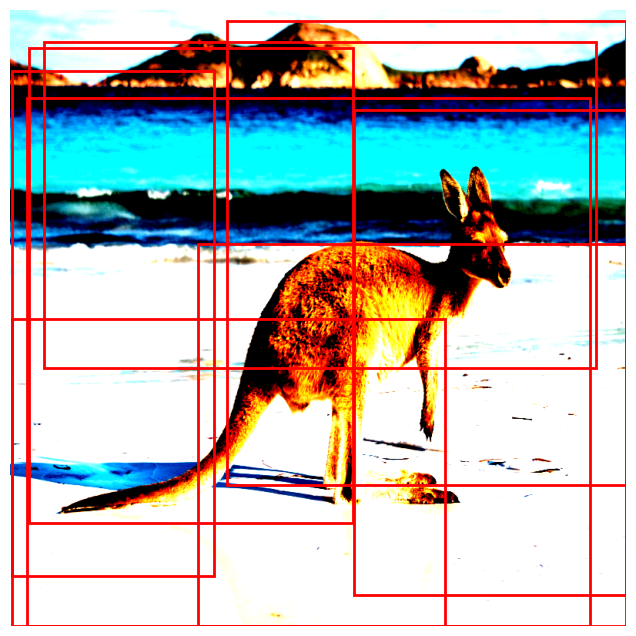

In [ ]:
def main(image_path, model, device):
    # Load and preprocess the image
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)

    # Make predictions
    outputs = predict(model, preprocessed_image, device)

    # Visualize the prediction
    visualize_prediction(preprocessed_image.squeeze(0), outputs)  # Remove batch dimension for visualization

# Example usage
image_path = "/content/Screenshot 2024-04-13 194949.png"  # Replace with your image path
main(image_path, model, device)
